# Figure S9
Plot timeseries of shelf temperature and salinity. 

In [1]:
import numpy as np
import xarray as xr
import gsw
import cftime
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34289/status,
Dashboard: /proxy/34289/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41125,Workers: 7
Dashboard: /proxy/34289/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:40045,Total threads: 4
Dashboard: /proxy/39439/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:43957,


Create database for control and perturbed experiments. 

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for ssp585_wind_thermal simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'

Define function to mask data to Antarctic continental shelf.

In [4]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

# Whole shelf timeseries

Define function to 1) read in temperature and salinity, 2) convert model salinity into absolute salinity and 3) volume average along shelf. 

In [5]:
def shelf_timeseries(expt, session, start_date, end_date):
    time_slice = slice(start_time, end_time)
    lat_slice = slice(-80,-60)
    
    # Read in variables
    variables = ['temp','salt','dzt','area_t']
    temp = cc.querying.getvar(expt,variables[0],session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
    salt_psu = cc.querying.getvar(expt,variables[1],session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
    dzt = cc.querying.getvar(expt,variables[2],session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
    area_t = cc.querying.getvar(expt,variables[3],session,n=1).sel(yt_ocean=lat_slice)

    # Convert practical salinity to absolute salinity using gsw routines 
    p = gsw.conversions.p_from_z(-temp.st_ocean, temp.yt_ocean)
    salt = gsw.conversions.SA_from_SP(salt_psu, p, salt_psu.xt_ocean,  salt_psu.yt_ocean)
    
    # Mask variables to shelf 
    temp, shelf_map = shelf_mask_isobath(temp)
    salt, shelf_map = shelf_mask_isobath(salt)
    dzt, shelf_map = shelf_mask_isobath(dzt)
    area_t, shelf_map = shelf_mask_isobath(area_t)
    
    # calculate volume of shelf grid cells
    vol = dzt*area_t
    vol_sum = vol.sum('xt_ocean').sum('yt_ocean').sum('st_ocean').load()

    # calculate volume averaged temperature and salinity
    temp = (temp*vol).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum
    temp = temp.load()
    salt = (salt*vol).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum
    salt = salt.load()
    
    return temp, salt
    

Now calculate the time series and save to file for each experiment. 

**Control:**

In [9]:
%%time
# CONTROL
start_time = '2150-01-01'
end_time = '2164-12-31'
expt = control
expt_short = 'control'
temp, salt = shelf_timeseries(expt, master_session, start_time, end_time)

# combine into one dataset
ds = temp.to_dataset(name='temp')
ds['salt'] = salt
ds['salt'].attrs['units:'] = 'Absolute salinity (g/kg)'
ds['temp'].attrs['units:'] = 'Conservative temperature (deg C)'
ds.attrs['long name:'] = f'Volume averaged shelf temperature and saltinity in {expt}'

# save to file
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_timeseries/'
outfile = outdir + f'whole_shelf_{expt_short}_{start_time}-{end_time}.nc'
ds.to_netcdf(outfile)

CPU times: user 20min 1s, sys: 58.2 s, total: 21min
Wall time: 31min 38s


**Experiments:**

In [12]:
%%time
expts = [ssp245mw_high]#][ssp245, ssp245mw, ssp585, ssp585mw]
expts_short = ['ssp245mw_high']#['ssp245','ssp245mw','ssp585','ssp585mw']
start_time = '2150-01-01'
end_time = '2164-12-31'
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_timeseries/'

for e, expt in enumerate(expts):
    print(expt, expts_short[e])

    # Read in volume averaged temperature and salinity for Antarctic continental shelf
    temp, salt = shelf_timeseries(expt, expt_session, start_time, end_time)

    # Combine into one dataset
    ds = temp.to_dataset(name='temp')
    ds['salt'] = salt
    ds['salt'].attrs['units:'] = 'Absolute salinity (g/kg)'
    ds['temp'].attrs['units:'] = 'Conservative temperature (deg C)'
    ds.attrs['long name:'] = f'Volume averaged shelf temperature and saltinity in {expt}'

    # Save to file
    outfile = outdir + f'whole_shelf_{expts_short[e]}_{start_time}-{end_time}.nc'
    ds.to_netcdf(outfile)

01deg_jra55v13_ssp245_windthermalmw_high ssp245mw_high
CPU times: user 25min 37s, sys: 2min 19s, total: 27min 57s
Wall time: 57min 48s


#### Plot temperature and salinity timeseries

Read in timeseries. 

In [6]:
start_time = '2150-01-01'
end_time = '2164-12-31'
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_timeseries/'

expt_ssp245 = 'ssp245'
expt_ssp245mw = 'ssp245mw'
expt_ssp585 = 'ssp585'
expt_ssp585mw = 'ssp585mw'

ctrl = xr.open_dataset(outdir + f'whole_shelf_control_{start_time}-{end_time}.nc')
ssp245_ts = xr.open_dataset(outdir + f'whole_shelf_{expt_ssp245}_{start_time}-{end_time}.nc')
ssp245mw_ts = xr.open_dataset(outdir + f'whole_shelf_{expt_ssp245mw}_{start_time}-{end_time}.nc')
ssp585_ts = xr.open_dataset(outdir + f'whole_shelf_{expt_ssp585}_{start_time}-{end_time}.nc')
ssp585mw_ts = xr.open_dataset(outdir + f'whole_shelf_{expt_ssp585mw}_{start_time}-{end_time}.nc')

Get temperature to plot in inset map to show masked shelf region. 

In [7]:
def map_shelf_temp(expt, session, start_date, end_date):
    time_slice = slice(start_time, end_time)
    lat_slice = slice(-80,-60)
    
    # Read in variables
    variables = ['temp','salt','dzt','area_t']
    temp = cc.querying.getvar(expt,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
    
    # Mask to shelf
    temp, shelf_map = shelf_mask_isobath(temp)
    temp = temp.isel(time=-1).sel(st_ocean = 100, method='nearest').load()
    
    return temp

shelf_temp = map_shelf_temp(control, master_session, start_time, end_time)

# topography data for plotting:
ht = cc.querying.getvar(control,'ht', master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

def add_circle_axes(fig, w, h, axes):
    a = axes.get_position()
    ax = fig.add_axes([0.03,0.78,w*a.width,h*a.height], projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    return ax

def colorbar_horz(cb, axes, label):
    fontsize=12
    cbaxes = fig.add_axes(axes)#[0.89, 0.55, 0.2, 0.015]
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'horizontal',extend = 'both')
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)
    return cbar

We want to use a rolling mean. To do this we read in some data from the Control in the 6 months before the experiments were branched. 

In [8]:
# read in variable for time data
temp_tmp = cc.querying.getvar(control,'temp',master_session,frequency='1 monthly',
                              start_time='2149-07-10', end_time='2149-12-31')


Now calculate mean from control. 

In [9]:
ctrl_mean = ctrl.groupby('time.month').mean().sel(month=slice(7,12))
ctrl_mean = ctrl_mean.rename({'month':'time'})
ctrl_mean['time'] = temp_tmp ['time'].values

Append to all timeseries. 

In [10]:
# now append to each timeseries
ctrl = xr.concat([ctrl_mean, ctrl], dim = 'time').load()
ssp245_ts = xr.concat([ctrl_mean, ssp245_ts], dim = 'time').load()
ssp245mw_ts = xr.concat([ctrl_mean, ssp245mw_ts], dim = 'time').load()
ssp585_ts = xr.concat([ctrl_mean, ssp585_ts], dim = 'time').load()
ssp585mw_ts = xr.concat([ctrl_mean, ssp585mw_ts], dim = 'time').load()

Define some plotting parameters

In [11]:
c1, c2, c3, c4 = '#ca0020', '#fdae61', '#92c5de', '#0571b0'
w,h = 0.7, 0.7
lw = 2

Plot figure

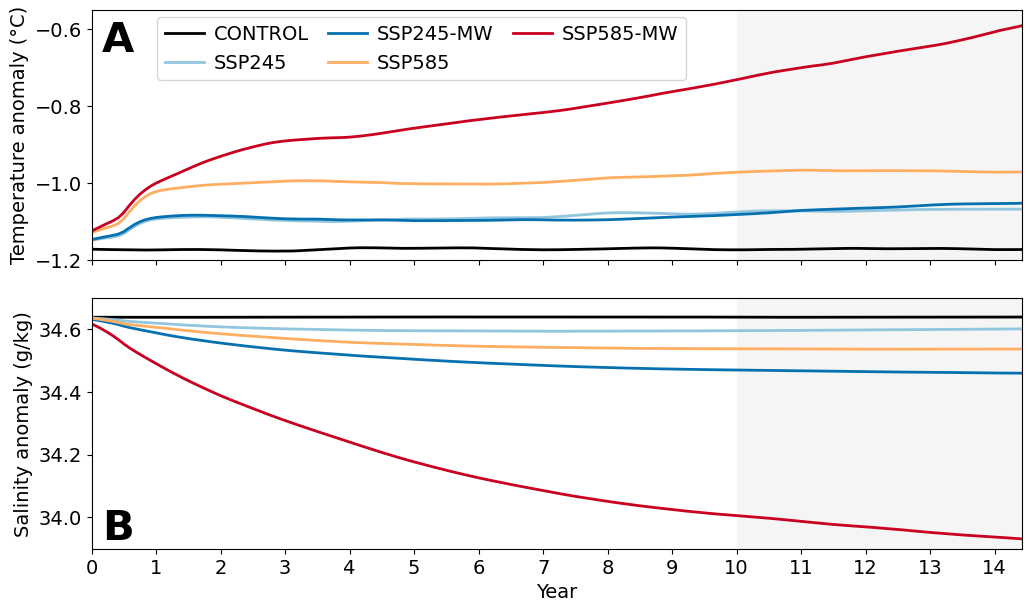

In [12]:
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,7), sharex=True)
plt.subplots_adjust(hspace=0.15)

axes[0].plot(np.arange(0,174,1), ctrl.temp.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c='k', lw=lw, label='CONTROL')
axes[0].plot(np.arange(0,174,1), ssp245_ts.temp.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c3, lw=lw, label='SSP245')
axes[0].plot(np.arange(0,174,1), ssp245mw_ts.temp.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c4, lw=lw, label='SSP245-MW')
axes[0].plot(np.arange(0,174,1), ssp585_ts.temp.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c2, lw=lw, label='SSP585')
axes[0].plot(np.arange(0,174,1), ssp585mw_ts.temp.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c1, lw=lw, label='SSP585-MW')
axes[0].set_ylabel('Temperature anomaly (\u00b0C)')
axes[0].legend(ncols=3, bbox_to_anchor=[0.06, 1.01], loc='upper left',  handletextpad=0.5, columnspacing=1,)

axes[1].plot(np.arange(0,174,1), ctrl.salt.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c='k', lw=lw, label='CONTROL')
axes[1].plot(np.arange(0,174,1), ssp245_ts.salt.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c3, lw=lw, label='SSP245')
axes[1].plot(np.arange(0,174,1), ssp245mw_ts.salt.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c4, lw=lw, label='SSP245-MW')
axes[1].plot(np.arange(0,174,1), ssp585_ts.salt.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c2, lw=lw, label='SSP585')
axes[1].plot(np.arange(0,174,1), ssp585mw_ts.salt.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), c=c1, lw=lw, label='SSP585-MW')
axes[1].set_ylabel('Salinity anomaly (g/kg)')

# set x limits and ticks
axes[1].set_xlim([0,173])
axes[1].set_xticks(np.arange(0,180,12))
axes[1].set_xticklabels(np.arange(0,15,1))
axes[1].set_xlabel('Year')

axes[0].text(2, -0.66, 'A',  c='k', fontsize=30, fontweight='bold',)
axes[1].text(2, 33.93, 'B',  c='k', fontsize=30, fontweight='bold',)
axes[0].fill_betweenx([-2, 1], 120, 174, color='whitesmoke')
axes[0].set_ylim([-1.2, -0.55])
axes[1].fill_betweenx([33, 35], 120, 174, color='whitesmoke')
axes[1].set_ylim([33.9, 34.7])

## SAVE FIGURE ##
figfile = '../figs/SuppFig_timeseries_shelf_average_rolling.jpg'
fig.savefig(figfile, dpi=200)
plt.show()